In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-6-6b09280b2460>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-6-6b09280b2460>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-6-6b09280b2460>:34: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')
MultiScaleTransformer(
  (embedding): Linear(in_features=5, out_features=64, bias=True)
  (pos_encoder): PositionalEncoding()
  (short_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
    

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch [1/5], Train Loss: 0.0027, Val Loss: 0.4842, Val RMSE: 0.6958, Val MAE: 0.4557, Val R²: -0.1361
Epoch [2/5], Train Loss: 0.0013, Val Loss: 0.3639, Val RMSE: 0.6032, Val MAE: 0.3746, Val R²: 0.1461
Epoch [3/5], Train Loss: 0.0008, Val Loss: 0.4935, Val RMSE: 0.7025, Val MAE: 0.4544, Val R²: -0.1580
Epoch [4/5], Train Loss: 0.0009, Val Loss: 0.5741, Val RMSE: 0.7577, Val MAE: 0.4801, Val R²: -0.3473
Epoch [5/5], Train Loss: 0.0006, Val Loss: 0.5136, Val RMSE: 0.7166, Val MAE: 0.4671, Val R²: -0.2052
No improvement, early stopping.
训练结束！


<ipython-input-6-6b09280b2460>:359: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))  # 加载最佳模型


Evaluation Results on Denormalized Scale (Test Set):
MSE: 821.4324
RMSE: 28.6606
MAE: 17.8002
R²: 0.1461


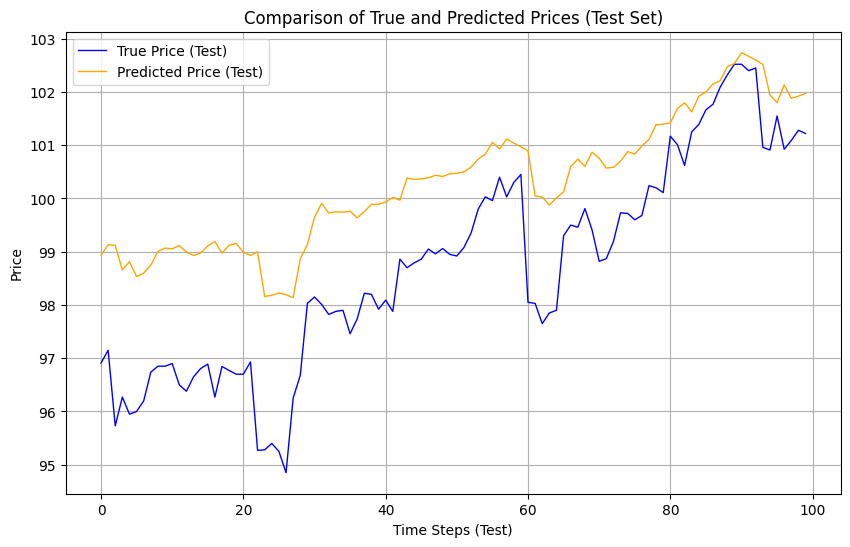

In [6]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, Subset
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler  # 改用 StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib

##########################################
# 数据读取与处理
##########################################
# 读取数据并预处理
df = pd.read_csv("/content/drive/MyDrive/Stock Prediction/JPM.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]  # 保持现有特征，不添加额外指标

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

# 重采样数据
df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

# 重命名列以区分不同频率数据
df_15min = df_15min.rename(columns=lambda c: c.lower() + "_15")
df_30min = df_30min.rename(columns=lambda c: c.lower() + "_30")
df_60min = df_60min.rename(columns=lambda c: c.lower() + "_60")

# 三个数据表通过时间索引 join (inner join)
df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

# 提取多尺度数据列
short_cols = [col + "_15" for col in feature_cols]  # ["open_15", "high_15", "low_15", "close_15", "volume_15"]
mid_cols = [col + "_30" for col in feature_cols]
long_cols = [col + "_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols

# 使用 StandardScaler 进行归一化
scaler = StandardScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 保存 scaler 以备将来使用
joblib.dump(scaler, 'standard_scaler.save')

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)

        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                target_seq,
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=256):  # 增加 mlp_hidden_dim
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1, 0, 2)  # (1, batch_size, d_model)

        short_embed = self.pos_encoder(short_embed).permute(1, 0, 2)  # (seq_len_short, batch_size, d_model)
        mid_embed = self.pos_encoder(mid_embed).permute(1, 0, 2)      # (seq_len_mid, batch_size, d_model)
        long_embed = self.pos_encoder(long_embed).permute(1, 0, 2)    # (seq_len_long, batch_size, d_model)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)  # (batch_size, 3*d_model)
        fusion_feat = fusion_feat.unsqueeze(-1)  # (batch_size, 3*d_model, 1)
        fusion_feat = self.conv_fusion(fusion_feat)  # (batch_size, d_model, 1)
        fusion_feat = fusion_feat.squeeze(-1)        # (batch_size, d_model)

        output = self.mlp(fusion_feat)  # (batch_size, output_dim)
        return output

##########################################
# 定义评价指标和验证函数
##########################################
def evaluate_metrics(y_true, y_pred):
    """
    计算评价指标：RMSE, MAE, R2
    """
    y_true = y_true.detach().cpu().numpy() if isinstance(y_true, torch.Tensor) else y_true
    y_pred = y_pred.detach().cpu().numpy() if isinstance(y_pred, torch.Tensor) else y_pred

    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    return rmse, mae, r2

def validate(model, val_loader, criterion, device):
    """
    在验证集上评估模型性能
    """
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for short_seq, mid_seq, long_seq, tgt_seq, label in val_loader:
            short_seq = short_seq.to(device)
            mid_seq = mid_seq.to(device)
            long_seq = long_seq.to(device)
            tgt_seq = tgt_seq.to(device)
            label = label.to(device)

            outputs = model(short_seq, mid_seq, long_seq, tgt_seq)
            loss = criterion(outputs, label)

            val_loss += loss.item() * short_seq.size(0)
            all_preds.append(outputs.detach().cpu())
            all_labels.append(label.detach().cpu())

    val_loss /= len(val_loader.dataset)
    all_preds = torch.cat(all_preds, dim=0).squeeze().numpy()
    all_labels = torch.cat(all_labels, dim=0).squeeze().numpy()

    rmse, mae, r2 = evaluate_metrics(all_labels, all_preds)
    return val_loss, rmse, mae, r2

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 定义超参数
feature_dim = len(feature_cols)  # 4
d_model = 64  # 增加隐藏层维度
nhead = 4     # 增加注意力头数
num_encoder_layers = 2  # 增加编码器层数
num_decoder_layers = 2  # 增加解码器层数
output_dim = 1
mlp_hidden_dim = 128    # 增加 MLP 隐藏层维度
lr = 1e-3
epochs = 5
patience = 3

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim, mlp_hidden_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)  # 引入学习率调度器

# 打印模型结构以确认
print(model)

# 检查一个 batch 的数据形状
for short_seq, mid_seq, long_seq, tgt_seq, label in train_dataloader:
    print("short_seq shape:", short_seq.shape)  # (batch_size, seq_len_short, 4)
    print("mid_seq shape:", mid_seq.shape)      # (batch_size, seq_len_mid, 4)
    print("long_seq shape:", long_seq.shape)    # (batch_size, seq_len_long, 4)
    print("tgt_seq shape:", tgt_seq.shape)      # (batch_size, 1, 4)
    print("label shape:", label.shape)          # (batch_size, 1)
    break  # 只打印第一个 batch

# 定义训练函数
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, device, epochs=100, patience=10):
    best_val_loss = float('inf')
    no_improve_count = 0

    for epoch in range(1, epochs + 1):
        model.train()
        epoch_loss = 0.0
        batch_count = 0

        for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_loader, start=1):
            short_seq = short_seq.to(device)
            mid_seq = mid_seq.to(device)
            long_seq = long_seq.to(device)
            tgt_seq = tgt_seq.to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(short_seq, mid_seq, long_seq, tgt_seq)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item() * short_seq.size(0)
            batch_count += short_seq.size(0)

        avg_train_loss = epoch_loss / batch_count

        # 验证阶段
        val_loss, val_rmse, val_mae, val_r2 = validate(model, val_loader, criterion, device)

        print(f"Epoch [{epoch}/{epochs}], "
              f"Train Loss: {avg_train_loss:.4f}, "
              f"Val Loss: {val_loss:.4f}, "
              f"Val RMSE: {val_rmse:.4f}, "
              f"Val MAE: {val_mae:.4f}, "
              f"Val R²: {val_r2:.4f}")

        # 学习率调度
        scheduler.step(val_loss)

        # 早停逻辑
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improve_count = 0
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            no_improve_count += 1
            if no_improve_count >= patience:
                print("No improvement, early stopping.")
                break

    print("训练结束！")

# 开始训练
train_model(model, train_dataloader, test_dataloader, criterion, optimizer, scheduler, device, epochs=epochs, patience=patience)

##########################################
# 在测试集上进行预测和评估
##########################################
model.load_state_dict(torch.load('best_model.pth'))  # 加载最佳模型
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

# 创建一个与 scaled data 相同维度的数组，只填充 close_15 列，其余列为0
preds_extended = np.zeros((num_samples, len(all_feature_cols)))
labels_extended = np.zeros((num_samples, len(all_feature_cols)))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

# 反归一化预测和实际值
inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels[:100], label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds[:100], label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


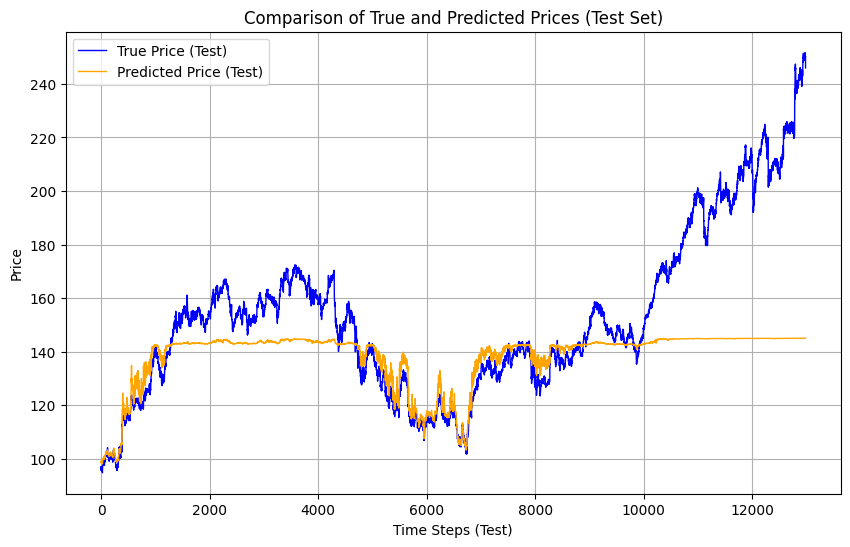

In [7]:
plt.figure(figsize=(10,6))
plt.plot(inv_labels[::], label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds[::], label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

<ipython-input-8-ee7cfb125c93>:31: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
<ipython-input-8-ee7cfb125c93>:32: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
<ipython-input-8-ee7cfb125c93>:33: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')


df_all columns: Index(['open_15', 'high_15', 'low_15', 'close_15', 'volume_15', 'open_30',
       'high_30', 'low_30', 'close_30', 'volume_30', 'open_60', 'high_60',
       'low_60', 'close_60', 'volume_60'],
      dtype='object')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
<ipython-input-8-ee7cfb125c93>:116: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(target_seq, dtype=torch.float32),


Epoch [1/10], Average Loss: 0.0010
Epoch [2/10], Average Loss: 0.0002
Epoch [3/10], Average Loss: 0.0002
Epoch [4/10], Average Loss: 0.0002
Epoch [5/10], Average Loss: 0.0001
Epoch [6/10], Average Loss: 0.0001
Epoch [7/10], Average Loss: 0.0001
Epoch [8/10], Average Loss: 0.0001
Epoch [9/10], Average Loss: 0.0001
Epoch [10/10], Average Loss: 0.0001
Evaluation Results on Denormalized Scale (Test Set):
MSE: 0.3542
RMSE: 0.5951
MAE: 0.4758
R²: 0.9934


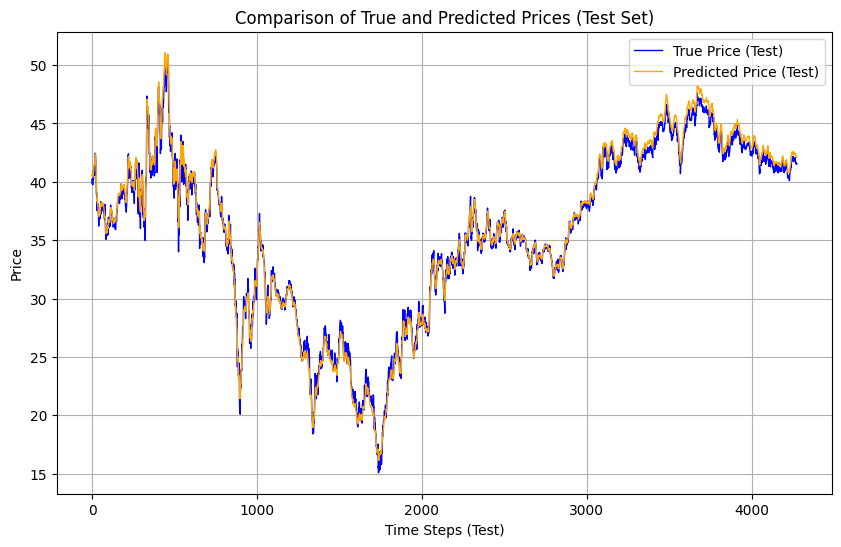

In [8]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

##########################################
# 数据读取与处理
##########################################
df = pd.read_csv("/content/drive/MyDrive/Stock Prediction/JPM.csv", parse_dates=["DateTime"], index_col="DateTime")
df = df.sort_index()
df = df.ffill()  # 前向填充

df = df[(df.index >= '2000-01-01') & (df.index <= '2010-01-01')]

df.columns = df.columns.str.lower()
feature_cols = ["open", "high", "low", "close", "volume"]

agg_dict = {
    "open": "first",
    "high": "max",
    "low": "min",
    "close": "last",
    "volume": "sum"
}

df_15min = df.resample("15T").agg(agg_dict).dropna(how='any')
df_30min = df.resample("30T").agg(agg_dict).dropna(how='any')
df_60min = df.resample("60T").agg(agg_dict).dropna(how='any')

df_15min = df_15min.rename(columns=lambda c: c.lower()+"_15")
df_30min = df_30min.rename(columns=lambda c: c.lower()+"_30")
df_60min = df_60min.rename(columns=lambda c: c.lower()+"_60")

df_all = df_15min.join(df_30min, how="inner").join(df_60min, how="inner")
print("df_all columns:", df_all.columns)

short_cols = [col+"_15" for col in feature_cols]
mid_cols = [col+"_30" for col in feature_cols]
long_cols = [col+"_60" for col in feature_cols]

all_feature_cols = short_cols + mid_cols + long_cols

# 使用MinMaxScaler进行归一化
scaler = MinMaxScaler()
df_all[all_feature_cols] = scaler.fit_transform(df_all[all_feature_cols])

# 数据划分为训练集和测试集（如80%训练，20%测试）
N = len(df_all)
train_ratio = 0.8
train_size = int(N * train_ratio)

train_df = df_all.iloc[:train_size]
test_df = df_all.iloc[train_size:]

train_short_data = train_df[short_cols].values
train_mid_data = train_df[mid_cols].values
train_long_data = train_df[long_cols].values
train_close_15_series = train_df["close_15"].values

test_short_data = test_df[short_cols].values
test_mid_data = test_df[mid_cols].values
test_long_data = test_df[long_cols].values
test_close_15_series = test_df["close_15"].values

seq_len_short = 16
seq_len_mid = 32
seq_len_long = 64

##########################################
# 定义Dataset
##########################################
class MultiScaleStockDataset(Dataset):
    def __init__(self, short_data, mid_data, long_data, close_label,
                 seq_len_short, seq_len_mid, seq_len_long):
        super().__init__()
        self.short_data = short_data
        self.mid_data = mid_data
        self.long_data = long_data
        self.close_label = close_label
        self.seq_len_short = seq_len_short
        self.seq_len_mid = seq_len_mid
        self.seq_len_long = seq_len_long

        self.length = len(short_data) - max(seq_len_short, seq_len_mid, seq_len_long) - 1
        if self.length < 1:
            raise ValueError("Not enough data to form a single sample.")

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        start = idx
        end_short = start + self.seq_len_short
        end_mid = start + self.seq_len_mid
        end_long = start + self.seq_len_long

        target_idx = end_short
        short_seq = self.short_data[start:end_short]
        mid_seq = self.mid_data[start:end_mid]
        long_seq = self.long_data[start:end_long]

        label = self.close_label[target_idx]
        # target_seq = torch.zeros(1, short_seq.shape[1])  # decoder输入为0
        # 将 target_seq 设置为短期序列的最后一个时间步的特征，而不是全零
        target_seq = torch.tensor(short_seq[-1], dtype=torch.float32).unsqueeze(0)  # shape: (1, num_features)


        return (torch.tensor(short_seq, dtype=torch.float32),
                torch.tensor(mid_seq, dtype=torch.float32),
                torch.tensor(long_seq, dtype=torch.float32),
                torch.tensor(target_seq, dtype=torch.float32),
                torch.tensor([label], dtype=torch.float32))


train_dataset = MultiScaleStockDataset(train_short_data, train_mid_data, train_long_data, train_close_15_series,
                                       seq_len_short, seq_len_mid, seq_len_long)
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)

test_dataset = MultiScaleStockDataset(test_short_data, test_mid_data, test_long_data, test_close_15_series,
                                      seq_len_short, seq_len_mid, seq_len_long)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

##########################################
# 模型定义
##########################################
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x

class MultiScaleTransformer(nn.Module):
    def __init__(self,
                 feature_dim,
                 d_model,
                 nhead,
                 num_encoder_layers,
                 num_decoder_layers,
                 output_dim,
                 mlp_hidden_dim=128):
        super(MultiScaleTransformer, self).__init__()

        self.embedding = nn.Linear(feature_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)

        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead)

        self.short_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.short_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.mid_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.mid_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.long_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_encoder_layers)
        self.long_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.conv_fusion = nn.Conv1d(in_channels=3*d_model, out_channels=d_model, kernel_size=1)

        self.mlp = nn.Sequential(
            nn.Linear(d_model, mlp_hidden_dim),
            nn.ReLU(),
            nn.Linear(mlp_hidden_dim, output_dim)
        )

    def forward(self, short_input, mid_input, long_input, target_seq):
        short_embed = self.embedding(short_input)
        mid_embed = self.embedding(mid_input)
        long_embed = self.embedding(long_input)

        tgt_embed = self.embedding(target_seq)
        tgt_embed = self.pos_encoder(tgt_embed).permute(1,0,2)

        short_embed = self.pos_encoder(short_embed).permute(1,0,2)
        mid_embed = self.pos_encoder(mid_embed).permute(1,0,2)
        long_embed = self.pos_encoder(long_embed).permute(1,0,2)

        short_enc = self.short_encoder(short_embed)
        mid_enc = self.mid_encoder(mid_embed)
        long_enc = self.long_encoder(long_embed)

        short_dec = self.short_decoder(tgt=tgt_embed, memory=short_enc)
        mid_dec = self.mid_decoder(tgt=tgt_embed, memory=mid_enc)
        long_dec = self.long_decoder(tgt=tgt_embed, memory=long_enc)

        short_feat = short_dec[0]
        mid_feat = mid_dec[0]
        long_feat = long_dec[0]

        fusion_feat = torch.cat([short_feat, mid_feat, long_feat], dim=-1)
        fusion_feat = fusion_feat.unsqueeze(-1)
        fusion_feat = self.conv_fusion(fusion_feat)
        fusion_feat = fusion_feat.squeeze(-1)

        output = self.mlp(fusion_feat)
        return output

##########################################
# 训练
##########################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

feature_dim = len(feature_cols) # now 4
d_model = 64
nhead = 4
num_encoder_layers = 2
num_decoder_layers = 2
output_dim = 1
lr = 1e-4
epochs = 10

model = MultiScaleTransformer(feature_dim, d_model, nhead, num_encoder_layers, num_decoder_layers, output_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

model.train()
for epoch in range(1, epochs+1):
    epoch_loss = 0.0
    batch_count = 0
    for i, (short_seq, mid_seq, long_seq, tgt_seq, label) in enumerate(train_dataloader, start=1):
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        optimizer.zero_grad()
        output = model(short_seq, mid_seq, long_seq, tgt_seq)
        loss = criterion(output, label)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * short_seq.size(0)
        batch_count += short_seq.size(0)

    avg_loss = epoch_loss / batch_count
    print(f"Epoch [{epoch}/{epochs}], Average Loss: {avg_loss:.4f}")

##########################################
# 在测试集上进行预测和评估
##########################################
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for (short_seq, mid_seq, long_seq, tgt_seq, label) in test_dataloader:
        short_seq = short_seq.to(device)
        mid_seq = mid_seq.to(device)
        long_seq = long_seq.to(device)
        tgt_seq = tgt_seq.to(device)
        label = label.to(device)

        pred = model(short_seq, mid_seq, long_seq, tgt_seq)
        all_preds.append(pred.cpu().numpy())
        all_labels.append(label.cpu().numpy())

all_preds = np.concatenate(all_preds, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

num_samples = all_preds.shape[0]
num_features = len(all_feature_cols)
close_15_index = all_feature_cols.index("close_15")

preds_extended = np.zeros((num_samples, num_features))
labels_extended = np.zeros((num_samples, num_features))

preds_extended[:, close_15_index] = all_preds[:, 0]
labels_extended[:, close_15_index] = all_labels[:, 0]

inv_preds = scaler.inverse_transform(preds_extended)[:, close_15_index]
inv_labels = scaler.inverse_transform(labels_extended)[:, close_15_index]

# 计算指标
mse = mean_squared_error(inv_labels, inv_preds)
rmse = np.sqrt(mse)
mae = mean_absolute_error(inv_labels, inv_preds)
r2 = r2_score(inv_labels, inv_preds)

print("Evaluation Results on Denormalized Scale (Test Set):")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# 画出测试集部分的对比图
plt.figure(figsize=(10,6))
plt.plot(inv_labels, label="True Price (Test)", color='blue', linewidth=1.0)
plt.plot(inv_preds, label="Predicted Price (Test)", color='orange', linewidth=1.0)
plt.title("Comparison of True and Predicted Prices (Test Set)")
plt.xlabel("Time Steps (Test)")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
# 可根据需要调整显示范围，例如：
# plt.ylim(20000, 22000)
plt.show()

In [12]:
test_df

,open_15,high_15,low_15,close_15,volume_15,open_30,high_30,low_30,close_30,volume_30,open_60,high_60,low_60,close_60,volume_60
DateTime,,,,,,,,,,,,,,,
2008-08-06 11:00:00,0.306724,0.308146,0.306900,0.310770,0.059936,0.306724,0.313440,0.307398,0.314847,0.095511,0.306724,0.313815,0.307398,0.317565,0.106071
2008-08-06 12:00:00,0.317658,0.320780,0.318639,0.323110,0.114370,0.317658,0.322585,0.319129,0.323246,0.125149,0.317658,0.319909,0.319129,0.318766,0.105330
2008-08-06 13:00:00,0.318859,0.317290,0.317801,0.318198,0.043747,0.318859,0.319817,0.318291,0.320006,0.055588,0.318859,0.316922,0.316375,0.315524,0.060645
2008-08-06 14:00:00,0.315615,0.316689,0.315046,0.319276,0.043445,0.315615,0.318734,0.315537,0.317366,0.065533,0.315615,0.317519,0.315537,0.318766,0.072805
2008-08-06 15:00:00,0.318979,0.319697,0.319957,0.319756,0.059908,0.318979,0.319697,0.318889,0.317006,0.077718,0.318979,0.316802,0.316136,0.313963,0.110924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2009-12-31 14:00:00,0.319700,0.319095,0.321754,0.322032,0.014013,0.319700,0.319456,0.322241,0.320966,0.023144,0.319700,0.317758,0.322241,0.322128,0.031251
2009-12-31 15:00:00,0.322103,0.320780,0.323431,0.323110,0.018627,0.322103,0.320780,0.323558,0.322046,0.033032,0.322103,0.317878,0.319727,0.317085,0.106558
2009-12-31 16:00:00,0.317177,0.320960,0.318519,0.318677,0.122463,0.317177,0.320960,0.319009,0.317606,0.083694,0.317177,0.318057,0.319009,0.318045,0.045062
